In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline
# General libraries.
import re
import time
import numpy as np
import tensorflow as tf
assert(tf.__version__.startswith("1.1"))
import matplotlib.pyplot as plt
import sys
import gensim
import nltk
import collections
import smart_open
import random

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *
from sklearn.svm import LinearSVC
from gensim.models import Word2Vec
from sklearn import metrics
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.grid_search import GridSearchCV
from pprint import pprint
from nltk import RegexpTokenizer
from nltk.corpus import stopwords

# Helper libraries
from shared_lib import utils, vocabulary, tf_embed_viz
nltk.download('stopwords')
reload(utils)

/home/svaradarajan1982/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/svaradarajan1982/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/svaradarajan1982/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<module 'shared_lib.utils' from 'shared_lib/utils.pyc'>

## 1. Contruct Paragraph2Vec Model¶
### Preview Input Data



In [2]:
# Get newsgroup data
newsgroup_data_all = fetch_20newsgroups(subset = 'all', remove=('headers', 'footers', 'quotes'))
#newsgroup_data_all.target += 1

print np.unique(newsgroup_data_all.target)

# List of all the class labels
label_list = list(newsgroup_data_all.target_names)

# Print the class labels
i = 0
for label in label_list:
    print "class: %i\t = %s" %(i, label)
    i += 1

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
class: 0	 = alt.atheism
class: 1	 = comp.graphics
class: 2	 = comp.os.ms-windows.misc
class: 3	 = comp.sys.ibm.pc.hardware
class: 4	 = comp.sys.mac.hardware
class: 5	 = comp.windows.x
class: 6	 = misc.forsale
class: 7	 = rec.autos
class: 8	 = rec.motorcycles
class: 9	 = rec.sport.baseball
class: 10	 = rec.sport.hockey
class: 11	 = sci.crypt
class: 12	 = sci.electronics
class: 13	 = sci.med
class: 14	 = sci.space
class: 15	 = soc.religion.christian
class: 16	 = talk.politics.guns
class: 17	 = talk.politics.mideast
class: 18	 = talk.politics.misc
class: 19	 = talk.religion.misc


### Select number of classes

In [3]:
from random import randint
random.seed(8)

num_class = 8
randomize = True

if randomize == True:
    label_idxs = []
    label_idxs = random.sample(range(0, 20), num_class)
else:
    label_idxs = range(num_class)

#select_classes = ['alt.atheism','rec.sport.baseball','talk.politics.mideast','comp.graphics', 'sci.space'] #[label_list[i] for i in label_idxs]
select_classes =  [label_list[i] for i in label_idxs]

print "Randomly Select Classes: ", select_classes
print "Class labels", label_idxs

newsgroups_all = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'),
                                    categories=select_classes)
#newsgroups_all.target += 1
print np.unique(newsgroups_all.target)

all_data, all_labels = newsgroups_all.data, newsgroups_all.target

Randomly Select Classes:  ['comp.sys.mac.hardware', 'talk.politics.misc', 'comp.os.ms-windows.misc', 'sci.crypt', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.med', 'talk.politics.mideast']
Class labels [4, 18, 2, 11, 1, 3, 13, 17]
[0 1 2 3 4 5 6 7]


### Preprocess Input Data

In [4]:
#Preprocessing for Doc2Vec 
# shuffle and split data
import copy
train_docs, train_labels, test_docs, test_labels = utils.get_train_test_docs(all_data, 
                                                                             all_labels, 
                                                                             split = 0.8, 
                                                                             shuffle = True)
print np.unique(train_labels)
# clean string
# remove stop words and take care of stemming
train_docs = utils.preprocess_doc(train_docs, fix_length = False)
test_docs = utils.preprocess_doc(test_docs, fix_length = False)
orig_test_labels = copy.copy(test_labels)

Loaded 7599 docs (1.04621e+07 tokens)
Training set: 6079 docs (8353083 tokens)
Test set: 1520 docs (2109064 tokens)
[0 1 2 3 4 5 6 7]


### Please Note LabeledSentence is a data structure of gesim's Doc2vec (paragraph) document format

In [5]:
from collections import namedtuple
from gensim.models.doc2vec import  LabeledSentence
import sys

all_newsgroup_documents = []
all_newsgroup_documents_20 = []

#Used to convert newsgroup corpus into Doc2Vec formats
def convert_newsgroup(docs,split):
    #global doc_count
    tagged_documents = []
    
    for i,v in enumerate(docs):
        label = '%s_%s'%(split,i)
        tagged_documents.append(LabeledSentence(v, [label]))
    
    return tagged_documents

In [6]:
test_docs = convert_newsgroup(test_docs,'test')
train_docs = convert_newsgroup(train_docs,'train')

all_newsgroup_documents.extend(train_docs)
all_newsgroup_documents.extend(test_docs)

doc_list = all_newsgroup_documents[:]  # for reshuffling per pass

print('%d docs: %d train, %d test' % (len(doc_list), len(train_docs), len(test_docs)))
print(len(train_labels))

7599 docs: 6079 train, 1520 test
6079


### Define Paragraph2Vec Model

In [7]:
from gensim.models import *
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

dbow_model = Doc2Vec(dm=0, dm_concat=1,sample=1e-5, size=450, window=5, negative=5, hs=0, min_count=2, workers=10)
dm_model =  Doc2Vec(dm=1, dm_mean=1, sample=1e-5, size=450, window=10, negative=5, hs=0, min_count=2, workers=10)
dbow_model.build_vocab(all_newsgroup_documents)
dm_model.build_vocab(all_newsgroup_documents)


dbow_dmm_model = ConcatenatedDoc2Vec([dbow_model, dm_model])

## Training Paragraph2Vec Model¶
### Please note
 Paragraph2vec only the vocabulary of giving data set  
 e.g. to train 5 + 1, select num_class = 6, to train 5 + 2, select num_class = 7


In [8]:
from random import shuffle
import progressbar
alpha, min_alpha, passes = (0.025, 0.001, 100)
alpha_delta = (alpha - min_alpha) / passes
bar = progressbar.ProgressBar()

for epoch in bar(range(passes)):
    shuffle(doc_list)
    #print alpha   
    dbow_model.alpha, dbow_model.min_alpha = alpha, alpha
    dbow_model.train(doc_list)
    
    dm_model.alpha, dm_model.min_alpha = alpha, alpha
    dm_model.train(doc_list)
    
    dbow_dmm_model.alpha, dbow_dmm_model.min_alpha = alpha, alpha
    dbow_dmm_model.train(doc_list)
    alpha -= alpha_delta

100% |########################################################################|


## Extract training and test vectors from the Paragraph2Vec Model¶

In [9]:
from collections import defaultdict
best_error = defaultdict(lambda :1.0)

#Get Vectors From Doc2Vec
def extract_vectors(model, docs):    
    vectors_list = []
    for doc_no in range(len(docs)):
        doc_label = docs[doc_no].tags[0] # Use tag to id
        doc_vector = model.docvecs[doc_label]
        vectors_list.append(doc_vector)      
    return vectors_list

# TODO inferred vectors
def get_infer_vectors(model,docs):   
    vecs = []
    for doc in docs:
        vecs.append(model.infer_vector(doc.words))
    return vecs

In [10]:
#train_docs_ids = np.array(extract_vectors(dbow_dmm_model,train_docs))
#test_docs_ids = np.array(extract_vectors(dbow_dmm_model,test_docs))
train_docs_ids = np.array(extract_vectors(dm_model,train_docs))
test_docs_ids = np.array(extract_vectors(dm_model,test_docs))


# Convert label to one-hot-code
train_labels_oh = np.eye(num_class)[train_labels]
test_labels_oh = np.eye(num_class)[test_labels]

print train_docs_ids.shape
print test_docs_ids.shape
print train_labels_oh.shape
print test_labels_oh.shape

(6079, 450)
(1520, 450)
(6079, 8)
(1520, 8)


## The following section is for comparing paragraphc2vec's performance with CNN
#### 1. Connect with the same output layer as CNN for classification  
#### 2. This is a multi-nomial classification. (not 1-vs-rest  

In [11]:
num_classes = num_class
feature_size = 450
l2_reg_lambda = 1.0
hidden = 250 # r

def display_params():
    print "number of classes: ", num_classes
    print "feature size: ", feature_size
    print "regularization: ", l2_reg_lambda
    print "hidden output size: ", hidden

In [12]:
# x_ is the Paragraph2vec input vectors
x_ = tf.placeholder(tf.float32, [None, feature_size], name="x")
y_ = tf.placeholder(tf.float32, [None, num_classes], name="y")
l2_loss = tf.constant(0.0)

# Output Layer: Softmax (1 layer version)
with tf.name_scope("Output_layer"):
            
    
    Z_ = tf.Variable(tf.random_uniform([feature_size, num_classes], -1.0, 1.0), name = "Z")
    b_ = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
    logits_ = tf.add(tf.matmul(x_, Z_), b_, name="logits")
    
    # L2 loss
    l2_loss += tf.nn.l2_loss(Z_)
    l2_loss += tf.nn.l2_loss(b_)
    
    #scores = tf.nn.xw_plus_b(h_drop, W, b, name="scores")
    predictions_ = tf.argmax(logits_, 1, name="predictions")

    
# Calculate mean cross-entropy loss
with tf.name_scope("cost_function"):
    per_example_losses_ = tf.nn.softmax_cross_entropy_with_logits(logits=logits_, 
                                                                 labels=y_,
                                                                 name="per_example_loss")
    loss_ = tf.reduce_mean(per_example_losses_) + l2_reg_lambda * l2_loss

# Accuracy
with tf.name_scope("accuracy"):
    correct_predictions_ = tf.equal(predictions_, tf.argmax(y_, 1))
    accuracy_ = tf.reduce_mean(tf.cast(correct_predictions_, "float"), name="accuracy")
    
with tf.name_scope("Training"):
    alpha_ = tf.placeholder(tf.float32, name="learning_rate")
    optimizer_ = tf.train.AdagradOptimizer(alpha_)
    #optimizer_ = tf.train.AdamOptimizer(alpha_)
    train_step_ = optimizer_.minimize(loss_)
    
# Initializer step
init_ = tf.global_variables_initializer()

## Training

In [13]:

# Helper functions for training
def train_batch(session, batch, alpha):
    # Feed last column as targets
    feed_dict = {x_:train_docs_ids,
                 y_:train_labels_oh,
                 alpha_:alpha}
    c, a, pred, _ = session.run([loss_, accuracy_, predictions_, train_step_],
                       feed_dict=feed_dict)
    return c, a, pred

def batch_generator(data, batch_size):
    """Generate minibatches from data."""
    for i in xrange(0, len(data), batch_size):
        yield data[i:i+batch_size]

def predict_batch(session):
    feed_dict = {x_:test_docs_ids,
                 y_:test_labels_oh}
    a, pred = session.run([accuracy_, predictions_], feed_dict=feed_dict)
    return a, pred

In [14]:
display_params()


number of classes:  8
feature size:  450
regularization:  1.0
hidden output size:  250


In [15]:
from shared_lib import utils

def run_epochs(num_epochs, batch_size, learning_rate, min_learning, print_rate):
    # One epoch = one pass through the training data
    num_epochs = num_epochs
    batch_size = batch_size
    alpha = learning_rate  # learning rate
    min_alpha = min_learning
    alpha_delta = (alpha - min_alpha) / num_epochs
    print_every = print_rate

    np.random.seed(42)

    # For plotting
    train_accuracy = []
    test_accuracy = []

    session = tf.Session()
    session.run(init_)

    t0 = time.time()
    for epoch in xrange(1,num_epochs+1):
        t0_epoch = time.time()
        epoch_cost = 0.0
        total_batches = 0
        print ""
        print "---------- Test ----------"
        print "[epoch %d] Learning Rate %.2f" %(epoch, alpha)
        for i, batch in enumerate(batch_generator(train_docs_ids, batch_size)):
            if (i % print_every == 0):
                print "[epoch %d] seen %d minibatches" % (epoch, i)

            cost, accuracy, pred = train_batch(session, batch, alpha)
            epoch_cost += cost
            total_batches = i + 1

        avg_cost = epoch_cost / total_batches
        alpha = alpha - alpha_delta

        print "[epoch %d] Completed %d minibatches in %s" % (epoch, i, utils.pretty_timedelta(since=t0_epoch))
        print "[epoch %d] Average cost: %.03f" % (epoch, avg_cost,)
        print "[epoch %d] Accuracy %.03f" %(epoch, accuracy)
        print "[epoch %d] Classificaiton Report\n" %(epoch)
        print classification_report(train_labels, pred)
        train_accuracy.append(accuracy)

        print ""
        print "---------- Test ----------"
        accuracy, pred = predict_batch(session)
        print "[epoch %d] Test Accuracy is %.03f" %(epoch, accuracy)
        print "[epoch %d] Test Classificaiton Report\n" %(epoch)
        print classification_report(test_labels, pred)
        test_accuracy.append(accuracy)
    return train_accuracy, test_accuracy

def plot_learning(num_epochs, train_accuracy, test_accuracy):
    plt.figure(figsize=(10, 8))
    plt.plot(range(0, num_epochs), train_accuracy, '.-', label = "Training accuracy")
    plt.plot(range(0, num_epochs), test_accuracy, '.-', label = "Test accuracy")
    plt.legend()
    plt.show()

### Running Epochs

In [16]:
train_accur, test_accur = run_epochs(num_epochs = 12, 
                                     batch_size = 100, 
                                     learning_rate = 0.5, 
                                     min_learning = 0.1, 
                                     print_rate = 100)


---------- Test ----------
[epoch 1] Learning Rate 0.50
[epoch 1] seen 0 minibatches
[epoch 1] Completed 60 minibatches in 0:00:02
[epoch 1] Average cost: 14.393
[epoch 1] Accuracy 0.378
[epoch 1] Classificaiton Report

             precision    recall  f1-score   support

          0       0.89      0.05      0.10       780
          1       0.27      0.85      0.41       819
          2       0.83      0.05      0.09       791
          3       0.79      0.14      0.23       767
          4       0.97      0.36      0.52       789
          5       0.37      0.94      0.53       773
          6       0.93      0.04      0.07       736
          7       0.39      0.61      0.48       624

avg / total       0.68      0.38      0.30      6079


---------- Test ----------
[epoch 1] Test Accuracy is 0.388
[epoch 1] Test Classificaiton Report

             precision    recall  f1-score   support

          0       0.45      0.62      0.53       193
          1       0.50      0.02      0.

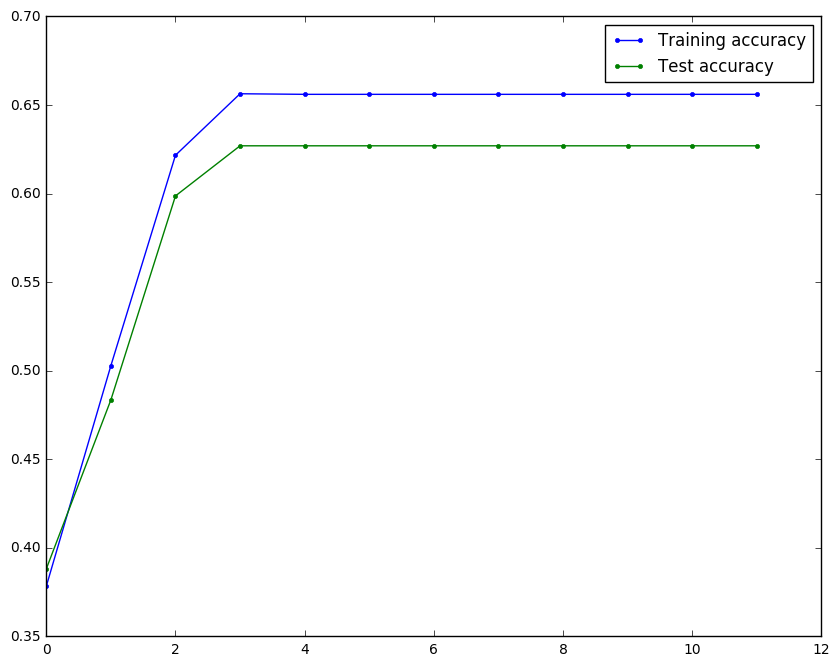

In [17]:
plot_learning(num_epochs = 12,
              train_accuracy = train_accur, 
              test_accuracy = test_accur)

In [18]:
tf.trainable_variables()


[<tf.Variable 'Output_layer/Z:0' shape=(450, 8) dtype=float32_ref>,
 <tf.Variable 'Output_layer/b:0' shape=(8,) dtype=float32_ref>]

## 2. Open Classificaiton Methods (1-vs-Rest)¶
  1-vs-Rest Layer of DOC
   M (number of class) sigmoid function, N (batch_size)
   Objective function for training is $$loss = \sum_{i=1}^M \sum_{i=1}^N y_n log(p) + (1 - y_n)log(1 - p(y))$$ is the    summation of all log loss (cross-entropy) on the training data.
  At prediction, reject if all predicted probability is less than their threshold t_i, otherwise $argmax(Sigmoid(d))$
  The theshold is determined by using outlier detection. (We can use a fixed number such as 0.95 to validate our model implementation)
  Approach:
   1. Remove some classes from the training data
   2. Training the data
   3. Add those classes back to the test data
  Clustering Approach
   1. KNN
   2. Gausian Mix Model
   3. Infinite Dirichlet process

In [20]:
print np.unique(train_labels)

[0 1 2 3 4 5 6 7]


## Remove some class and cross validate train data for hyper parameters¶


In [19]:
## Load SKlearn libraries
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.metrics import f1_score

### Training and test data are feature vectors from paragraph2vec model


In [20]:
## Training and test data are feature vectors from paragraph2vec model
#train_vectors = extract_vectors(dbow_dmm_model,train_docs)
#test_vectors = extract_vectors(dbow_dmm_model,test_docs)

train_vectors = extract_vectors(dm_model,train_docs)
test_vectors = extract_vectors(dm_model,test_docs)

train_valid_cut = int(len(train_vectors)*0.8)
valid_final_vectors=train_vectors[train_valid_cut:]
valid_final_labels = train_labels[train_valid_cut:]

train_new_vectors = train_vectors[:train_valid_cut]
train_new_labels = train_labels[:train_valid_cut]

# Define a missing class and remove those data from the training set
missing_class = np.array([0,2,5])
missing_class_idx = np.where(np.isin(train_new_labels, missing_class))[0]
train_final_vectors = [train_new_vectors[i] for i in range(len(train_new_vectors)) if i not in missing_class_idx]
train_final_labels = [train_new_labels[i] for i in range(len(train_new_labels)) if i not in missing_class_idx]

val_missing_class_idx = np.where(np.isin(valid_final_labels, missing_class))[0]
valid_calib_vectors = [valid_final_vectors[i] for i in range(len(valid_final_vectors)) if i not in val_missing_class_idx]
valid_calib_labels = [valid_final_labels[i] for i in range(len(valid_final_labels)) if i not in val_missing_class_idx]


#train_final_vectors = train_new_vectors[:train_valid_cut]
#train_final_labels = train_new_labels[:train_valid_cut]


print np.array(train_vectors).shape
print np.array(train_final_vectors).shape
print np.array(train_final_labels).shape

print np.array(valid_final_vectors).shape
print np.array(valid_final_labels).shape

print np.array(valid_calib_vectors).shape
print np.array(valid_calib_labels).shape


print np.array(test_vectors).shape
print np.array(test_labels).shape
print np.unique(train_final_labels)
print np.unique(valid_final_labels)
print np.unique(valid_calib_labels)
print np.unique(test_labels)

(6079, 450)
(2980, 450)
(2980,)
(1216, 450)
(1216,)
(755, 450)
(755,)
(1520, 450)
(1520,)
[1 3 4 6 7]
[0 1 2 3 4 5 6 7]
[1 3 4 6 7]
[0 1 2 3 4 5 6 7]


In [21]:
# Method 1 Logistic Regression 1-vs-Rest
clf_lr = LogisticRegression(solver='sag',
                         multi_class = 'ovr',
                         C=1,
                         penalty='l2',
                         tol = 0.001,
                         fit_intercept=True)
clf_lr.fit(train_final_vectors, train_final_labels)

parameters_lr = {
    "C": [0.001,0.01,0.1,0.5,1,2,5],
    "tol": [0.001, 0.0005, 0.0001],
    "solver": ["newton-cg", "sag", "lbfgs"],
}

print "--- 1-vs-Rest Logistic Regression ---"
mod_lr = GridSearchCV(estimator=clf_lr, param_grid=parameters_lr, scoring='f1_macro', verbose=True)
mod_lr.fit(valid_calib_vectors, valid_calib_labels)
print mod_lr.best_score_ 
print mod_lr.best_params_

# Method 2 SVM 1-vs-Rest
clf_svc = OneVsRestClassifier(SVC(probability=True))
clf_svc.fit(train_final_vectors, train_final_labels)

parameters_SVC = {
    "estimator__C": [0.001],  #[0.001,0.01,0.1,0.5,1,2,5],
    "estimator__kernel": ["poly","rbf", "sigmoid","linear"],#["poly","rbf", "sigmoid","linear"],
    "estimator__degree": [3, 4] #[1, 2, 3, 4],
}

print "--- 1-vs-Rest SVM ---"
mod_svc = GridSearchCV(estimator=clf_svc, param_grid=parameters_SVC, scoring='f1_macro', verbose=True)
mod_svc.fit(valid_calib_vectors, valid_calib_labels)
print mod_svc.best_score_ 
print mod_svc.best_params_

/home/svaradarajan1982/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


--- 1-vs-Rest Logistic Regression ---
Fitting 3 folds for each of 63 candidates, totalling 189 fits


[Parallel(n_jobs=1)]: Done 189 out of 189 | elapsed:  1.5min finished


0.777111296478
{'C': 1, 'tol': 0.001, 'solver': 'newton-cg'}
--- 1-vs-Rest SVM ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/home/svaradarajan1982/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   41.0s finished


0.718426256787
{'estimator__kernel': 'linear', 'estimator__C': 0.001, 'estimator__degree': 3}


In [22]:
print np.unique(train_final_labels)
print np.unique(test_labels)

[1 3 4 6 7]
[0 1 2 3 4 5 6 7]


### Calibrate 1-vs-Rest probability

In [23]:
clf_lr = LogisticRegression(solver=mod_lr.best_params_['solver'],
                            multi_class = 'ovr',
                            C=mod_lr.best_params_['C'],
                            penalty='l2',
                            tol = mod_lr.best_params_['tol'],
                            fit_intercept=True)

clf_svc = OneVsRestClassifier(SVC(probability=True, 
                              kernel=mod_svc.best_params_['estimator__kernel'], 
                              C=mod_svc.best_params_['estimator__C'], 
                              degree=mod_svc.best_params_['estimator__degree']))

clf_lr.fit(train_final_vectors, train_final_labels)
clf_svc.fit(train_final_vectors, train_final_labels)

## Calibrate prob
sig_clf_lr = CalibratedClassifierCV(clf_lr, method="sigmoid", cv="prefit")
sig_clf_svc = CalibratedClassifierCV(clf_svc, method="sigmoid", cv="prefit")
sig_clf_lr.fit(valid_calib_vectors, valid_calib_labels)
sig_clf_svc.fit(valid_calib_vectors, valid_calib_labels)

sig_clf_lr_probs = sig_clf_lr.predict_proba(test_vectors)
sig_clf_svc_probs = sig_clf_svc.predict_proba(test_vectors)

clf_lr_probs = clf_lr.predict_proba(test_vectors)
clf_svc_probs = clf_svc.predict_proba(test_vectors)

sig_class_max_prob_lists = np.array([max(sig_clf_lr_probs[:,val]) for val in range(len(sig_clf_lr_probs[0]))])
sig_class_min_prob_lists = np.array([min(sig_clf_lr_probs[:,val]) for val in range(len(sig_clf_lr_probs[0]))])
sig_delta = sig_class_max_prob_lists - sig_class_min_prob_lists

class_max_prob_lists = np.array([max(clf_lr_probs[:,val]) for val in range(len(clf_lr_probs[0]))])
class_min_prob_lists = np.array([min(clf_lr_probs[:,val]) for val in range(len(clf_lr_probs[0]))])
delta = class_max_prob_lists - class_min_prob_lists

# Normalized for test vector
scaled_calib_sig_lr_probs = np.divide(sig_clf_lr_probs,sig_delta)
scaled_calib_lr_probs = np.divide(clf_lr_probs,delta)

/home/svaradarajan1982/anaconda2/lib/python2.7/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/svaradarajan1982/anaconda2/lib/python2.7/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/svaradarajan1982/anaconda2/lib/python2.7/site-packages/sklearn/calibration.py:447: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)


### Visualized histogram of max probability (probability that determine the class)¶


In [25]:
scaled_calib_sig_lr_probs

array([[  5.12782674e-01,   3.75735920e-01,   1.17885972e-03,
          6.53207635e-02,   4.50469501e-02],
       [  2.69943129e-01,   2.38165167e-01,   1.70526021e-01,
          1.78321609e-01,   1.43081746e-01],
       [  5.84154746e-01,   8.32536586e-02,   1.42333058e-01,
          1.18630068e-01,   7.17025632e-02],
       ..., 
       [  5.34230077e-01,   1.85685521e-01,   1.49543265e-01,
          7.38676421e-02,   5.67410753e-02],
       [  2.50342883e-01,   6.04739281e-02,   1.06370566e-01,
          4.16433769e-01,   1.66417796e-01],
       [  3.79801069e-03,   1.05987021e-07,   6.12593833e-04,
          3.43094218e-06,   9.95586711e-01]])

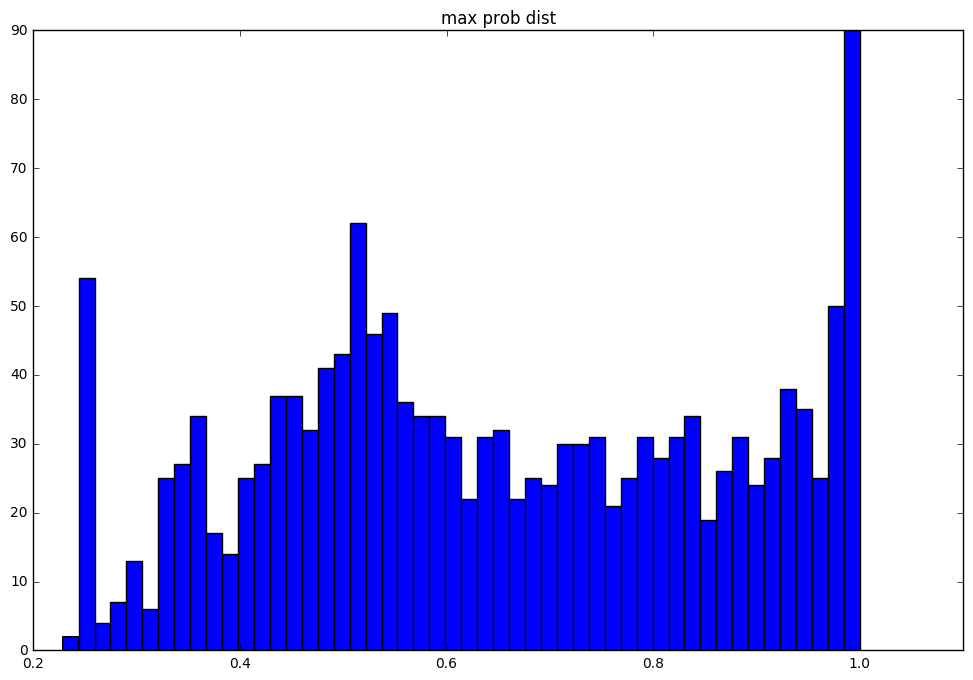

In [26]:
x = np.amax(scaled_calib_lr_probs, axis = 1)
#x = scaled_calib_lr_probs[:,0]
plt.figure(figsize = (12, 8))
n, bins, patches = plt.hist(x, 50)
plt.title("max prob dist")
plt.show()

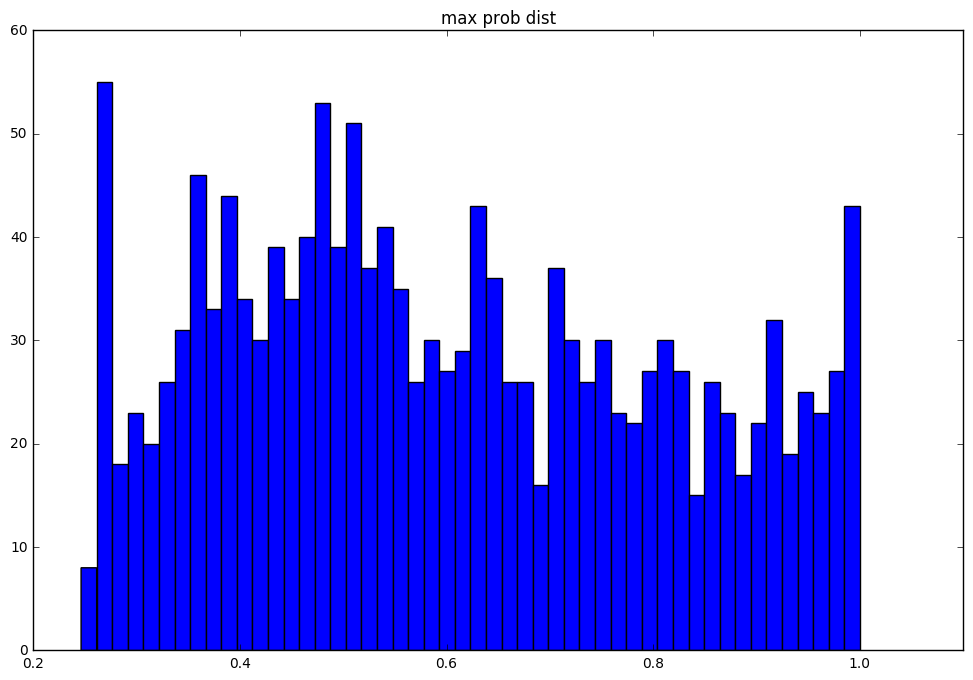

In [27]:
x = np.amax(scaled_calib_sig_lr_probs, axis = 1)
#print x
plt.figure(figsize = (12, 8))
n, bins, patches = plt.hist(x, 50)
plt.title("max prob dist")
plt.show()

## Check Classification Accuracy on Test Data
  Test Data actually have 5 class labels  
  Try with training data of 4 labels first

In [28]:
preds1 = clf_lr.predict(test_vectors)
preds2 = sig_clf_lr.predict(test_vectors)
print np.unique(preds1)
print np.unique(preds2)
print classification_report(test_labels,preds1)
print classification_report(test_labels,preds2)
print accuracy_score(test_labels,preds1)
print accuracy_score(test_labels,preds2)

[1 3 4 6 7]
[1 3 4 6 7]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       193
          1       0.30      0.88      0.45       166
          2       0.00      0.00      0.00       191
          3       0.47      0.82      0.60       196
          4       0.60      0.78      0.68       202
          5       0.00      0.00      0.00       217
          6       0.85      0.84      0.85       204
          7       0.49      0.75      0.59       151

avg / total       0.34      0.49      0.39      1520

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       193
          1       0.28      0.89      0.43       166
          2       0.00      0.00      0.00       191
          3       0.46      0.81      0.59       196
          4       0.61      0.77      0.68       202
          5       0.00      0.00      0.00       217
          6       0.86      0.82      0.84       204
          7       

/home/svaradarajan1982/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## To find the new class, we select a Percentile for Probability Threshold for Class Labels¶

In [29]:
class_prob_percentile_85 = np.array([np.percentile(scaled_calib_sig_lr_probs[:,val], 90.0) 
                                     for val in range(len(scaled_calib_sig_lr_probs[0]))])

test_class_preds = np.greater_equal(scaled_calib_sig_lr_probs,class_prob_percentile_85).astype(int)

# Predict the test label based on percental
# If a data is below 80% for prob of all class, it belongs to open class
valid_class_probs = np.multiply(scaled_calib_sig_lr_probs, test_class_preds)
valid_class = np.greater_equal(np.ceil(valid_class_probs),1).astype(int)
predicted_multinomial = np.multiply(valid_class, np.unique(train_final_labels))
predicted_test_class = np.max(predicted_multinomial,axis=1)

# The true unseen class index
unseen_class_indices = np.where(np.isin(test_labels, missing_class))[0]

In [30]:
print "predicted test classes", np.unique(predicted_test_class)
print "train labels", np.unique(train_final_labels)
print "Full list of original test labels", np.unique(orig_test_labels)


predicted test classes [0 1 3 4 6 7]
train labels [1 3 4 6 7]
Full list of original test labels [0 1 2 3 4 5 6 7]


## Evaluate F1 Score/Precision/Recall with Unseen Class¶


In [31]:
import copy
orig_valid_labels = copy.copy(valid_final_labels)

missing_class_idx_test = np.where(np.isin(test_labels, missing_class))[0]
missing_class_idx_val = np.where(np.isin(valid_final_labels, missing_class))[0]

#print missing_class_idx_test
#orig_test_labels = copy.copy(test_labels)
for i in range(len(test_labels)): 
    if i in missing_class_idx_test:
        test_labels[i] = 0
        
for i in range(len(valid_final_labels)): 
    if i in missing_class_idx_val:
        valid_final_labels[i] = 0

In [32]:
print classification_report(test_labels, predicted_test_class)
print accuracy_score(test_labels, predicted_test_class)

             precision    recall  f1-score   support

          0       0.54      0.69      0.61       601
          1       0.53      0.48      0.50       166
          3       0.73      0.57      0.64       196
          4       0.79      0.59      0.68       202
          6       0.94      0.70      0.80       204
          7       0.57      0.57      0.57       151

avg / total       0.65      0.63      0.63      1520

0.627631578947


## Unseen Class Predictions¶

In [33]:
print np.bincount(sorted(predicted_test_class[unseen_class_indices]))
print sum(np.bincount(sorted(predicted_test_class[unseen_class_indices])))

[414  66   0  39  25   0   3  54]
601


### Unseen Class Prediction Accuracy¶

In [34]:
print float(np.bincount(sorted(predicted_test_class[unseen_class_indices]))[0]), \
    sum(np.isin(test_labels, missing_class).astype(int))
print float(np.bincount(sorted(predicted_test_class[unseen_class_indices]))[0])/sum(np.isin(test_labels, missing_class).astype(int))

414.0 601
0.688851913478


## Perform dimensionality reduction 

In [35]:
import pandas as pd
import numpy as np

train_final_vectors = np.array(train_final_vectors)
valid_final_vectors=np.array(valid_final_vectors)
test_vectors=np.array(test_vectors)
print train_final_vectors.shape
print valid_final_vectors.shape
print test_vectors.shape


X = train_final_vectors
y = train_final_labels

X_val = valid_final_vectors
y_val = valid_final_labels

X_test = test_vectors
y_test = test_labels

feat_cols = [ 'col'+str(i) for i in range(X.shape[1]) ]
feat_cols_val = [ 'col'+str(i) for i in range(X_val.shape[1]) ]
feat_cols_test = [ 'col'+str(i) for i in range(X_test.shape[1]) ]

df = pd.DataFrame(X,columns=feat_cols)
df['label'] = y
df['label'] = df['label'].apply(lambda i: str(i))


df_val = pd.DataFrame(X_val,columns=feat_cols_val)
df_val['label'] = y_val
df_val['label'] = df_val['label'].apply(lambda i: str(i))

df_test = pd.DataFrame(X_test,columns=feat_cols_test)
df_test['label'] = y_test
df_test['label'] = df_test['label'].apply(lambda i: str(i))


X, y = None, None
print 'Size of the train dataframe: {}'.format(df.shape)
print 'Size of the test dataframe: {}'.format(df_val.shape)
print 'Size of the test dataframe: {}'.format(df_test.shape)

N = df.shape[0]
print N

(2980, 450)
(1216, 450)
(1520, 450)
Size of the train dataframe: (2980, 451)
Size of the test dataframe: (1216, 451)
Size of the test dataframe: (1520, 451)
2980


In [36]:
np.array(train_final_vectors).shape

(2980, 450)

In [37]:
np.unique(valid_final_labels)

array([0, 1, 3, 4, 6, 7])

In [38]:
df[feat_cols].values.shape

(2980, 450)

# Using Latent Semantic Analysis

In [39]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import logging
from optparse import OptionParser
import sys
from time import time
import numpy as np
from sklearn.decomposition import TruncatedSVD

print("Performing dimensionality reduction using LSA")
t0 = time()
svd = TruncatedSVD(n_components=20)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

lsa_result = lsa.fit_transform(df[feat_cols].values)
lsa_val = lsa.fit_transform(df_val[feat_cols].values)
lsa_test = lsa.transform(df_test[feat_cols_test].values)

print("done in %fs" % (time() - t0))

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

Performing dimensionality reduction using LSA
done in 0.097997s
Explained variance of the SVD step: 75%


# Using Principal Component Analysis

In [40]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
#df['pca-three'] = pca_result[:,2]
#df['pca-four'] = pca_result[:,3]
#df['pca-five'] = pca_result[:,4]


print 'Explained variation per principal component: {}'.format(pca.explained_variance_ratio_)
print 'Explained variation All components: {}'.format(sum(pca.explained_variance_ratio_))


Explained variation per principal component: [ 0.13703431  0.06091758  0.05849279  0.04908736  0.04529564  0.03628968
  0.0327381   0.02994966  0.02758154  0.02671706  0.02437125  0.02220082
  0.02062441  0.02011169  0.0186812   0.01803586  0.0161721   0.01580175
  0.0146184   0.01298685]
Explained variation All components: 0.687708041631


# Fit Gaussian Mixture Models of varying components and covariance matrix sizes

In [50]:
import itertools
import operator
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from sklearn.mixture import BayesianGaussianMixture

from sklearn import mixture

print(__doc__)


def GMM_fits(input_data=lsa_result, max_comp=21):
    # Number of samples per component
    n_samples = N
    # Generate random sample, two components
    np.random.seed(0)
    X = np.array(input_data)
    #X=np.array(pca_result_5)
    print X.shape

    bic_2 = {}
    n_components_range = range(max_comp, max_comp+1)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    aic_dict = {}
    bic_dict = {}
    lowest_bic = np.infty
    lowest_aic = np.infty

    for cv_type in cv_types:

        bic = []
        aic = []
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type, reg_covar =1e-3,random_state=0, init_params='kmeans',max_iter = 1350)
            gmm.fit(X)
            bic.append(gmm.bic(X))
            aic.append(gmm.aic(X))
            bic_2[cv_type+"-" + str(n_components)] = gmm.bic(X)
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
            if aic[-1] < lowest_aic:
                lowest_aic = aic[-1]

        aic_dict[cv_type] = aic
        bic_dict[cv_type] = bic

    clf = best_gmm
    sorted_bic_2 = sorted(bic_2.items(), key=operator.itemgetter(1))
    return clf, bic_dict, aic_dict, sorted_bic_2, lowest_bic, lowest_aic 

def BGMM_fits(input_data=lsa_result, cv_type='full', max_comp=21):
    mod = BayesianGaussianMixture(n_components=max_comp, covariance_type='full', weight_concentration_prior_type="dirichlet_process", reg_covar=0, init_params='random',
        max_iter=1500, mean_precision_prior=.8,random_state=0)
    X = np.array(input_data)
    mod.fit(X)
    return mod


Automatically created module for IPython interactive environment


# BIC Plots

In [40]:
def plot_model_selection_criteria(best_model, aic_dict, bic_dict, information_criteria = 'bic', max_comp = 21):
    n_components_range = range(1,max_comp)
    if information_criteria == 'bic':
        for cv in bic_dict.keys():
            plt.plot(n_components_range, bic_dict[cv], label=str(cv))
            #plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
            plt.legend(loc=cv)
            plt.xlabel('n_components_range')
        plt.title("BIC plot")
    else:
        for cv in aic_dict.keys():
            plt.plot(n_components_range, aic_dict[cv], label=str(cv))
            #plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
            plt.legend(loc=cv)
            plt.xlabel('n_components_range')
        plt.title("AIC plot")


In [51]:
num_train_class = 5
num_unseen_class =3

In [52]:
best_lsa_model = BGMM_fits(input_data=lsa_result, max_comp=num_train_class)

In [53]:
#plot_model_selection_criteria(best_model=best_lsa_model, aic_dict=lsa_aic_d, bic_dict=lsa_bic_d,information_criteria='bic',max_comp=num_class-1)
#print "Lowest_BIC", lowest_lsa_bic
#print "Lowest_AIC", lowest_lsa_aic  
print "Best GMM Model Parameters based on BIC", best_lsa_model.get_params

Best GMM Model Parameters based on BIC <bound method BayesianGaussianMixture.get_params of BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=None, init_params='random',
            max_iter=1500, mean_precision_prior=0.8, mean_prior=None,
            n_components=5, n_init=1, random_state=0, reg_covar=0,
            tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=None,
            weight_concentration_prior_type='dirichlet_process')>


Homogeneity: 0.231
Completeness: 0.257
V-measure: 0.243
Adjusted Rand-Index: 0.175
Silhouette Coefficient: -0.046
fowlkes_mallows_score: 0.371


(array([  247.,     0.,   600.,     0.,     0.,   359.,     0.,  1285.,
            0.,   489.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ]),
 <a list of 10 Patch objects>)

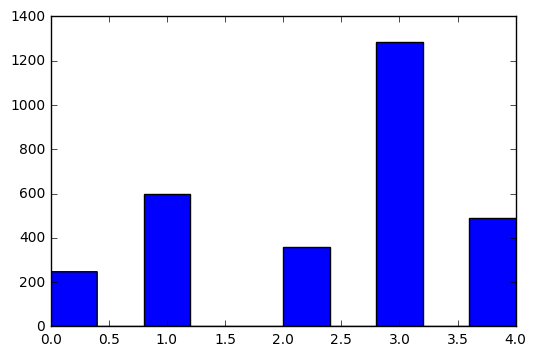

In [54]:
predicted_cluster = best_lsa_model.predict(lsa_result)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(df['label'], predicted_cluster))
print("Completeness: %0.3f" % metrics.completeness_score(df['label'], predicted_cluster))
print("V-measure: %0.3f" % metrics.v_measure_score(df['label'], predicted_cluster))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(df['label'], predicted_cluster))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(lsa_result, predicted_cluster, sample_size=1000))
print ("fowlkes_mallows_score: %.3f"
      % metrics.fowlkes_mallows_score(df['label'], predicted_cluster))

plt.hist(predicted_cluster)

In [55]:
def print_cluster_comp(predicted_labels,actual_labels):
    Cluster_ids = {}
    for i in predicted_labels:
        Cluster_ids[i] = (predicted_labels==i).nonzero()[0]

    targets = np.array(actual_labels)
    #print Cluster_ids
    for label in Cluster_ids.keys():
        #print type(label)
        idx = Cluster_ids[label]
        print "Cluster Number", str(label), "Composition", np.bincount(targets[idx])
        print "\n"

In [56]:
print print_cluster_comp(predicted_labels=predicted_cluster, actual_labels=train_final_labels)

Cluster Number 0 Composition [  0   1   0   3   3   0 209  31]


Cluster Number 1 Composition [  0   4   0   3  58   0 231 304]


Cluster Number 2 Composition [  0 128   0  77  62   0  40  52]


Cluster Number 3 Composition [  0 395   0 396 434   0  24  36]


Cluster Number 4 Composition [  0 118   0 128  76   0  85  82]


None


# Validation Data Prediction

In [57]:
pred_proba_val_labels = best_lsa_model.predict_proba(lsa_val)

In [58]:
print pred_proba_val_labels
val_gmm_class_max_prob_lists = np.array([max(pred_proba_val_labels[:,val]) for val in range(len(pred_proba_val_labels[0]))])
val_gmm_class_min_prob_lists = np.array([min(pred_proba_val_labels[:,val]) for val in range(len(pred_proba_val_labels[0]))])
val_gmm_delta = val_gmm_class_max_prob_lists - val_gmm_class_min_prob_lists

print val_gmm_delta
# Normalized for test vector
scaled_gmm_val_class_probs = np.divide(pred_proba_val_labels,val_gmm_delta)
print scaled_gmm_val_class_probs

[[  1.58430819e-039   9.30523962e-009   8.50886286e-098   1.26248218e-011
    9.99999991e-001]
 [  2.89255924e-002   5.51135042e-001   1.93139440e-002   3.97190695e-001
    3.43472723e-003]
 [  2.91886124e-020   2.96456717e-004   4.48064001e-029   4.39576702e-003
    9.95307776e-001]
 ..., 
 [  2.31759863e-011   4.05841368e-002   4.95569505e-054   1.45195539e-010
    9.59415863e-001]
 [  3.81278014e-006   3.73461498e-001   4.71461373e-025   9.62753131e-003
    6.16907158e-001]
 [  2.81692333e-076   2.71241443e-036   1.83845688e-216   1.24485873e-022
    1.00000000e+000]]
[ 0.9417429   0.9988858   0.99975188  0.99905046  0.99999979]
[[  1.68231498e-039   9.31561909e-009   8.51097459e-098   1.26368210e-011
    1.00000020e+000]
 [  3.07149565e-002   5.51749802e-001   1.93187373e-002   3.97568202e-001
    3.43472795e-003]
 [  3.09942472e-020   2.96787398e-004   4.48175202e-029   4.39994496e-003
    9.95307986e-001]
 ..., 
 [  2.46096744e-011   4.06294061e-002   4.95692495e-054   1.45333539

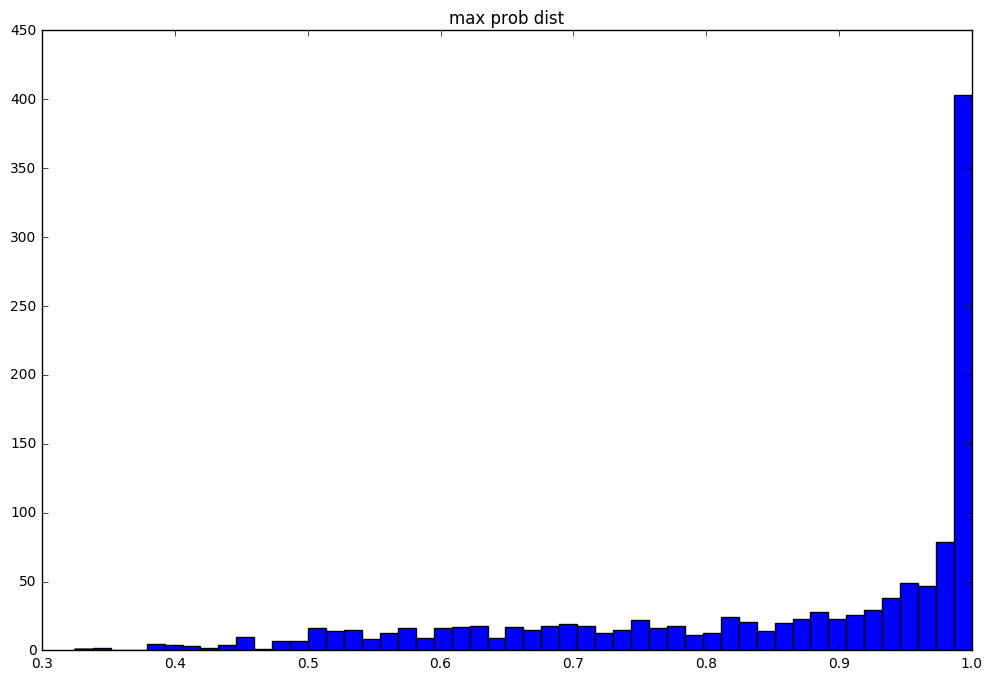

In [59]:
x = np.amax(pred_proba_val_labels, axis = 1)
#print pred_proba_test_labels[:,0]
plt.figure(figsize = (12, 8))
n, bins, patches = plt.hist(x, 50)
plt.title("max prob dist")
plt.show()

In [60]:
class_threshold = 85.0
val_gmm_class_prob_percentile_cutoff = np.array([np.percentile(scaled_gmm_val_class_probs[:,val], class_threshold) 
                                     for val in range(len(scaled_gmm_val_class_probs[0]))])

print val_gmm_class_prob_percentile_cutoff

gmm_val_class_preds = np.greater_equal(scaled_gmm_val_class_probs,val_gmm_class_prob_percentile_cutoff).astype(int)

print scaled_gmm_val_class_probs
# Predict the test label based on percental
# If a data is below 80% for prob of all class, it belongs to open class
val_gmm_valid_class_probs = np.multiply(scaled_gmm_val_class_probs, gmm_val_class_preds)
val_gmm_valid_class = np.greater_equal(np.ceil(val_gmm_valid_class_probs),1).astype(int)
print val_gmm_valid_class
val_gmm_predicted_multinomial = np.multiply(val_gmm_valid_class, np.unique(train_final_labels))
print np.unique(np.sum(val_gmm_predicted_multinomial, axis=1))
gmm_predicted_val_class = np.max(val_gmm_predicted_multinomial,axis=1)


[  1.63926291e-03   7.54106305e-01   1.41965000e-07   7.49496415e-01
   9.99830059e-01]
[[  1.68231498e-039   9.31561909e-009   8.51097459e-098   1.26368210e-011
    1.00000020e+000]
 [  3.07149565e-002   5.51749802e-001   1.93187373e-002   3.97568202e-001
    3.43472795e-003]
 [  3.09942472e-020   2.96787398e-004   4.48175202e-029   4.39994496e-003
    9.95307986e-001]
 ..., 
 [  2.46096744e-011   4.06294061e-002   4.95692495e-054   1.45333539e-010
    9.59416065e-001]
 [  4.04864227e-006   3.73878074e-001   4.71578380e-025   9.63668174e-003
    6.16907287e-001]
 [  2.99118084e-076   2.71543998e-036   1.83891315e-216   1.24604190e-022
    1.00000021e+000]]
[[0 0 0 0 1]
 [1 0 1 0 0]
 [0 0 0 0 0]
 ..., 
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 1]]
[ 0  1  3  4  5  6  7  8 10 11]


In [61]:
print np.bincount(valid_final_labels), np.bincount(gmm_predicted_val_class)
print np.sum(np.bincount(valid_final_labels)), np.sum(np.bincount(gmm_predicted_val_class))

[461 173   0 160 156   0 147 119] [521  34   0 166 129   0 183 183]
1216 1216


# Calculate Unseen Class Precision, Recall, F1 Score

In [62]:
print "Composition of gmm_predicted_valid_class for true unseen class indices", np.bincount(sorted(gmm_predicted_val_class[missing_class_idx_val]))
print sum(np.bincount(sorted(gmm_predicted_val_class[missing_class_idx_val])))

Composition of gmm_predicted_valid_class for true unseen class indices [176  23   0  66  56   0  74  66]
461


In [63]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
print classification_report(gmm_predicted_val_class, valid_final_labels)
print confusion_matrix(gmm_predicted_val_class, valid_final_labels)


             precision    recall  f1-score   support

          0       0.38      0.34      0.36       521
          1       0.02      0.09      0.03        34
          3       0.14      0.14      0.14       166
          4       0.11      0.13      0.12       129
          6       0.07      0.05      0.06       183
          7       0.16      0.10      0.13       183

avg / total       0.23      0.20      0.21      1216

[[176  71  63  76  73  62]
 [ 23   3   3   0   4   1]
 [ 66  14  23   8  30  25]
 [ 56  23  15  17   8  10]
 [ 74  36  31  30  10   2]
 [ 66  26  25  25  22  19]]


In [64]:
def calculate_unseen_class_f1score(pred_class, true_class, unseen_class_id):
    predicted_zero_ind = (pred_class==unseen_class_id).nonzero()[0]
    predicted_nonzero_ind = (pred_class >unseen_class_id).nonzero()[0]
    #print np.bincount(true_class[predicted_zero_ind])[0]
    TP = np.bincount(true_class[predicted_zero_ind])[0]
    FP =  sum(np.bincount(true_class[predicted_zero_ind])) - TP
    FN =  np.bincount(true_class[predicted_nonzero_ind])[0]
    #print TP, FP, FN
    unseen_class_precision = float(TP)/(TP+FP)
    unseen_class_recall = float(TP)/(TP+FN)
    unseen_class_f1 = 2*unseen_class_precision*unseen_class_recall/(unseen_class_precision+unseen_class_recall)
    #print unseen_class_precision,unseen_class_recall,unseen_class_f1
    return unseen_class_precision, unseen_class_recall,unseen_class_f1
    
pr,re,f1 = calculate_unseen_class_f1score(gmm_predicted_val_class,valid_final_labels,0)
print pr,re,f1


0.337811900192 0.381778741866 0.358452138493


In [65]:
best_threshold = 0.0
best_f1_score=0.0
for threshold in range(50,95):
    try:
        val_gmm_class_prob_percentile_cutoff = np.array([np.percentile(scaled_gmm_val_class_probs[:,val], float(threshold)) 
                                             for val in range(len(scaled_gmm_val_class_probs[0]))])

        #print val_gmm_class_prob_percentile_cutoff

        gmm_val_class_preds = np.greater_equal(scaled_gmm_val_class_probs,val_gmm_class_prob_percentile_cutoff).astype(int)

        #print scaled_gmm_val_class_probs
        # Predict the test label based on percental
        # If a data is below 80% for prob of all class, it belongs to open class
        val_gmm_valid_class_probs_dup = np.multiply(scaled_gmm_val_class_probs, gmm_val_class_preds)

        val_gmm_valid_class_max_probs = np.max(val_gmm_valid_class_probs_dup, axis=1)
        #print gmm_valid_class_max_probs
        #print type(gmm_valid_class_probs_dup),  type(gmm_valid_class_max_probs)
        val_temp = np.equal(val_gmm_valid_class_probs_dup , val_gmm_valid_class_max_probs.reshape(len(val_gmm_valid_class_max_probs),1))
        val_gmm_valid_class_probs=np.multiply(val_gmm_valid_class_probs_dup,val_temp)
        val_gmm_valid_class = np.greater_equal(np.ceil(val_gmm_valid_class_probs),1).astype(int)
        #print val_gmm_valid_class
        val_gmm_predicted_multinomial = np.multiply(val_gmm_valid_class, np.unique(train_final_labels))
        #print np.unique(np.sum(val_gmm_predicted_multinomial, axis=1))
        gmm_predicted_val_class = np.max(val_gmm_predicted_multinomial,axis=1)  
        print np.unique(gmm_predicted_val_class), np.unique(valid_final_labels)
        pr,re,f1 = calculate_unseen_class_f1score(gmm_predicted_val_class,valid_final_labels,0)
        print "Threshold: ",threshold, "F1 Score: ", f1 
        print "Actual Unseen Class", np.bincount(valid_final_labels)[0], "Predicted Unseen Class",np.bincount(gmm_predicted_val_class)[0]
        # Set the threshold so that not unseen class volume is actual unseen class volume in validation set
        unseen_class_ratio = float(np.bincount(gmm_predicted_val_class)[0])/np.bincount(valid_final_labels)[0]
        #overall_F1_score = f1_score(gmm_predicted_val_class, valid_final_labels)
        if f1 > best_f1_score and unseen_class_ratio < 1.1:

            best_f1_score = f1
            best_threshold = threshold
    except:
        print "Threshold Too Low. No unseen class prediction"
        
print "Best Threshold: ", best_threshold
print "Best F1 Score: ", best_f1_score

[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class prediction
[1 3 4 6 7] [0 1 3 4 6 7]
Threshold Too Low. No unseen class pre

# Test Data Prediction

In [66]:
pred_proba_test_labels = best_lsa_model.predict_proba(lsa_test)

In [67]:
print pred_proba_test_labels
gmm_class_max_prob_lists = np.array([max(pred_proba_test_labels[:,val]) for val in range(len(pred_proba_test_labels[0]))])
gmm_class_min_prob_lists = np.array([min(pred_proba_test_labels[:,val]) for val in range(len(pred_proba_test_labels[0]))])
gmm_delta = gmm_class_max_prob_lists - gmm_class_min_prob_lists

print gmm_delta
# Normalized for test vector
scaled_gmm_test_class_probs = np.divide(pred_proba_test_labels,gmm_delta)
print scaled_gmm_test_class_probs

[[  1.39415122e-008   9.51799197e-003   9.96159861e-017   9.11754466e-001
    7.87275284e-002]
 [  7.13255655e-104   1.07295082e-028   3.34286138e-162   5.20039676e-017
    1.00000000e+000]
 [  2.10876361e-008   1.34060010e-004   1.19340084e-021   3.80162604e-001
    6.19703315e-001]
 ..., 
 [  7.17384796e-016   7.44391105e-007   3.40084435e-012   9.70883261e-001
    2.91159947e-002]
 [  1.28929254e-005   8.59637238e-001   7.45185263e-043   4.39917903e-004
    1.39909951e-001]
 [  4.65676855e-014   8.92597426e-001   1.85942657e-057   6.43640534e-012
    1.07402574e-001]]
[ 0.9980932   0.99932038  0.99979163  0.99904947  0.99999987]
[[  1.39681467e-008   9.52446499e-003   9.96367472e-017   9.12621937e-001
    7.87275387e-002]
 [  7.14618292e-104   1.07368052e-028   3.34355806e-162   5.20534458e-017
    1.00000013e+000]
 [  2.11279229e-008   1.34151181e-004   1.19364956e-021   3.80524303e-001
    6.19703396e-001]
 ..., 
 [  7.18755321e-016   7.44897353e-007   3.40155312e-012   9.71806990

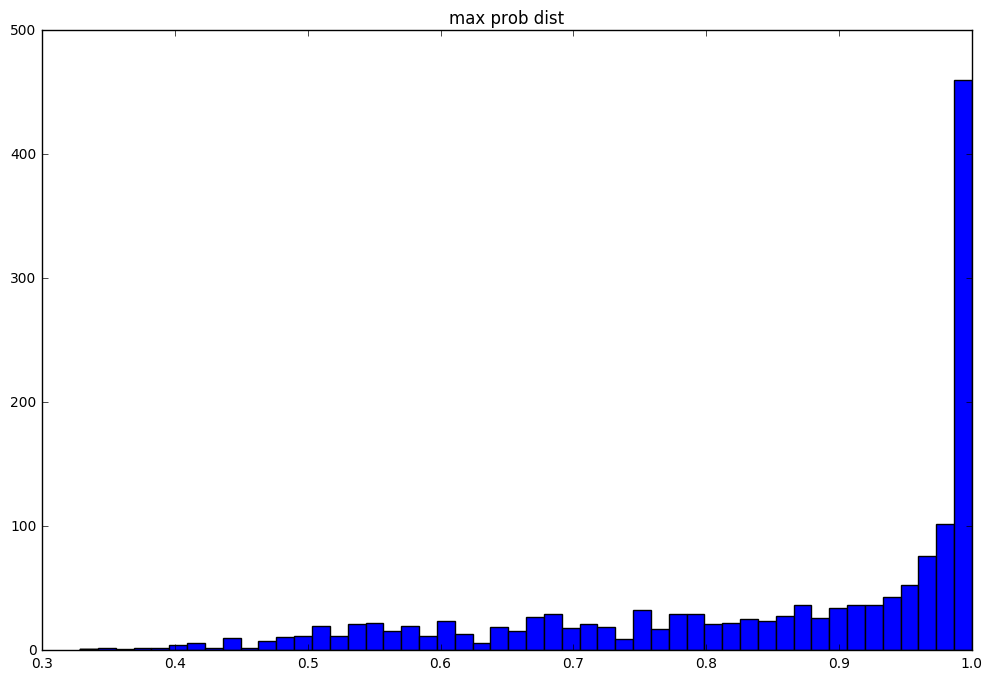

In [68]:
x = np.amax(pred_proba_test_labels, axis = 1)
#print pred_proba_test_labels[:,0]
plt.figure(figsize = (12, 8))
n, bins, patches = plt.hist(x, 50)
plt.title("max prob dist")
plt.show()

In [69]:
np.unique(train_final_labels)

array([1, 3, 4, 6, 7])

In [70]:
print best_threshold
gmm_class_prob_percentile_cutoff = np.array([np.percentile(scaled_gmm_test_class_probs[:,val], best_threshold) 
                                     for val in range(len(scaled_gmm_test_class_probs[0]))])

#print gmm_class_prob_percentile_cutoff

gmm_test_class_preds = np.greater_equal(scaled_gmm_test_class_probs,gmm_class_prob_percentile_cutoff).astype(int)

#print scaled_gmm_test_class_probs
# Predict the test label based on percental
# If a data is below 80% for prob of all class, it belongs to open class
gmm_valid_class_probs_dup = np.multiply(scaled_gmm_test_class_probs, gmm_test_class_preds)
print gmm_valid_class_probs_dup
gmm_valid_class_max_probs = np.max(gmm_valid_class_probs_dup, axis=1)
print gmm_valid_class_max_probs
#print type(gmm_valid_class_probs_dup),  type(gmm_valid_class_max_probs)
temp = np.equal(gmm_valid_class_probs_dup , gmm_valid_class_max_probs.reshape(len(gmm_valid_class_max_probs),1))
gmm_valid_class_probs=np.multiply(gmm_valid_class_probs_dup,temp)
gmm_valid_class = np.greater_equal(np.ceil(gmm_valid_class_probs),1).astype(int)
print gmm_valid_class
gmm_predicted_multinomial = np.multiply(gmm_valid_class, np.unique(train_final_labels))
print np.unique(np.sum(gmm_predicted_multinomial, axis=1))
gmm_predicted_test_class = np.max(gmm_predicted_multinomial,axis=1)

# The true unseen class index
#unseen_class_indices = np.where(np.isin(test_labels, missing_class))[0]

84
[[ 0.          0.          0.          0.91262194  0.        ]
 [ 0.          0.          0.          0.          1.00000013]
 [ 0.          0.          0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.          0.97180699  0.        ]
 [ 0.          0.86022186  0.          0.          0.        ]
 [ 0.          0.89320447  0.          0.          0.        ]]
[ 0.91262194  1.00000013  0.         ...,  0.97180699  0.86022186
  0.89320447]
[[0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 0 0 0]
 ..., 
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 1 0 0 0]]
[0 1 3 4 6 7]


In [71]:
print np.bincount(test_labels), np.bincount(gmm_predicted_test_class)
print np.sum(np.bincount(test_labels)), np.sum(np.bincount(gmm_predicted_test_class))


[601 166   0 196 202   0 204 151] [590 101   0 244  97   0 244 244]
1520 1520


In [72]:
print confusion_matrix(test_labels, gmm_predicted_test_class)

[[224  58  88  45 106  80]
 [ 60   9  15  15  41  26]
 [ 67  12  28  11  48  30]
 [ 74   5  26  12  33  52]
 [102   6  43   8  11  34]
 [ 63  11  44   6   5  22]]


In [73]:
print classification_report(test_labels, gmm_predicted_test_class)
print accuracy_score(test_labels, gmm_predicted_test_class)

             precision    recall  f1-score   support

          0       0.38      0.37      0.38       601
          1       0.09      0.05      0.07       166
          3       0.11      0.14      0.13       196
          4       0.12      0.06      0.08       202
          6       0.05      0.05      0.05       204
          7       0.09      0.15      0.11       151

avg / total       0.21      0.20      0.20      1520

0.201315789474


In [74]:
#print "Composition of gmm_predicted_test_class for true unseen class indices", np.bincount(sorted(gmm_predicted_test_class[unseen_class_indices]))
#print sum(np.bincount(sorted(gmm_predicted_test_class[unseen_class_indices])))

## Unseen Class Precision, Recall F1 Score

In [75]:
print "Unseen Class Precision: ", calculate_unseen_class_f1score(gmm_predicted_test_class,test_labels,0)[0]
print "Unseen Class Recall: ", calculate_unseen_class_f1score(gmm_predicted_test_class,test_labels,0)[1]
print "Unseen Class F1 Score: ", calculate_unseen_class_f1score(gmm_predicted_test_class,test_labels,0)[2]


Unseen Class Precision:  0.379661016949
Unseen Class Recall:  0.372712146423
Unseen Class F1 Score:  0.376154492024


In [76]:
#print float(np.bincount(sorted(gmm_predicted_test_class[unseen_class_indices]))[0]), \
#    sum(np.isin(test_labels, missing_class).astype(int))
#print float(np.bincount(sorted(gmm_predicted_test_class[unseen_class_indices]))[0])/sum(np.isin(test_labels, missing_class).astype(int))

In [77]:
#print np.bincount(gmm_predicted_test_class)
pred_class_indices = (gmm_predicted_test_class==0).nonzero()[0]
#print len(pred_class_indices)
#print "Composition of predicted Unseen Class in terms of actual test labels",np.bincount(orig_test_labels[pred_class_indices])

In [78]:
#print np.bincount(orig_test_labels[pred_class_indices])

In [79]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(df_test['label'], gmm_predicted_test_class))
print("Completeness: %0.3f" % metrics.completeness_score(df_test['label'], gmm_predicted_test_class))
print("V-measure: %0.3f" % metrics.v_measure_score(df_test['label'], gmm_predicted_test_class))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(df_test['label'], gmm_predicted_test_class))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(lsa_test, gmm_predicted_test_class, sample_size=1000))
print ("fowlkes_mallows_score: %.3f"
      % metrics.fowlkes_mallows_score(df_test['label'], gmm_predicted_test_class))

Homogeneity: 0.026
Completeness: 0.027
V-measure: 0.026
Adjusted Rand-Index: -0.001
Silhouette Coefficient: -0.112
fowlkes_mallows_score: 0.232


# Further Clustering Unseen Class

In [80]:
predicted_unseen_class_lsa= lsa_test[pred_class_indices]

/home/svaradarajan1982/anaconda2/lib/python2.7/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


fowlkes_mallows_score: 0.381


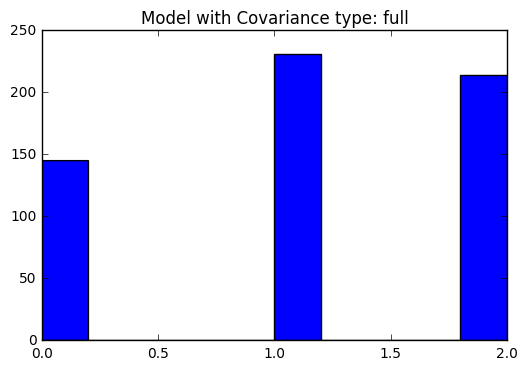

fowlkes_mallows_score: 0.394


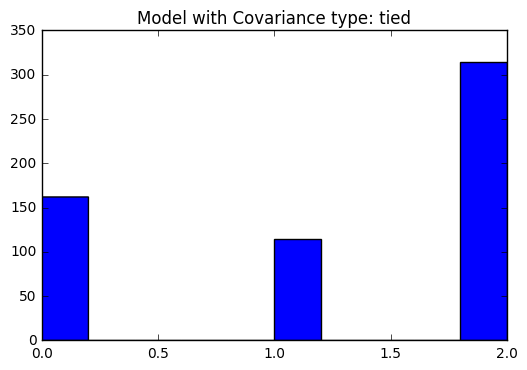

fowlkes_mallows_score: 0.420


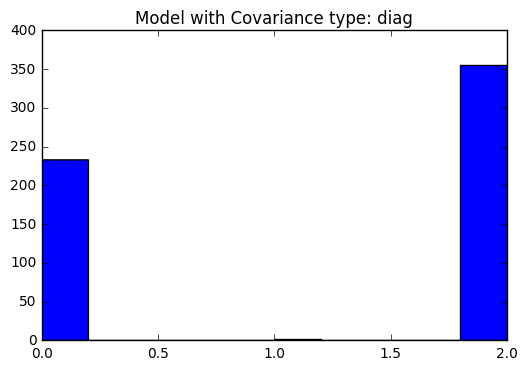

fowlkes_mallows_score: 0.371


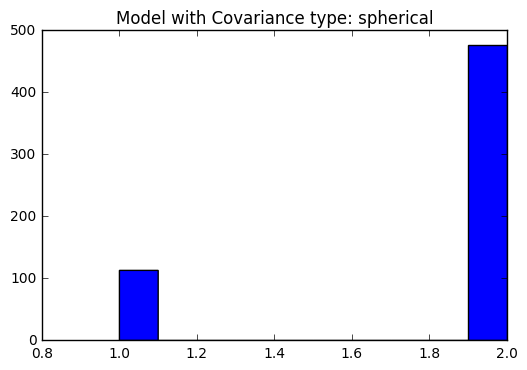

In [81]:
from sklearn.mixture import BayesianGaussianMixture

c_var = ['full', 'tied', 'diag', 'spherical']
n_components=3
models = [BayesianGaussianMixture(n_components, covariance_type=c, init_params='random').fit(predicted_unseen_class_lsa)
          for c in c_var]

for m in range(len(models)):
    plt.title("Model with Covariance type: " + str(c_var[m]))
    plt.hist(models[m].predict(predicted_unseen_class_lsa))
    pred_ls = models[m].predict(predicted_unseen_class_lsa)
    print ("fowlkes_mallows_score: %.3f"
      % metrics.fowlkes_mallows_score(pred_ls, orig_test_labels[pred_class_indices]))
    plt.show()
#gmm2_model.